# Logistic regression
The purpose of this notebook is to understand and implement logistic regression. As always, you are not allowed to use any package that has a complete logistic regression framework implemented (e.g., scikit-learn).

Logistic regression, despite its name, is a linear model for classification rather than regression. In its original form, it is used for binary classifications, i.e., assigning a data point in our test set a binary label (e.g., yes or no, 0 or 1, red or blue). The reason why the term logistic *regression* is used becomes obvious once we examine the logistic function (often also called sigmoind function):
$$
f(x) = \frac{1}{1+e^{-x}}
$$
Next, you will implement the logistic function using numpy.

In [1]:
# importing standard packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_moons

In [2]:
## EDIT THIS FUNCTION
def logistic(x):
    return 1 / (1 + np.exp(-x)) ## <-- SOLUTION

Let's plot the function to see how it behaves.

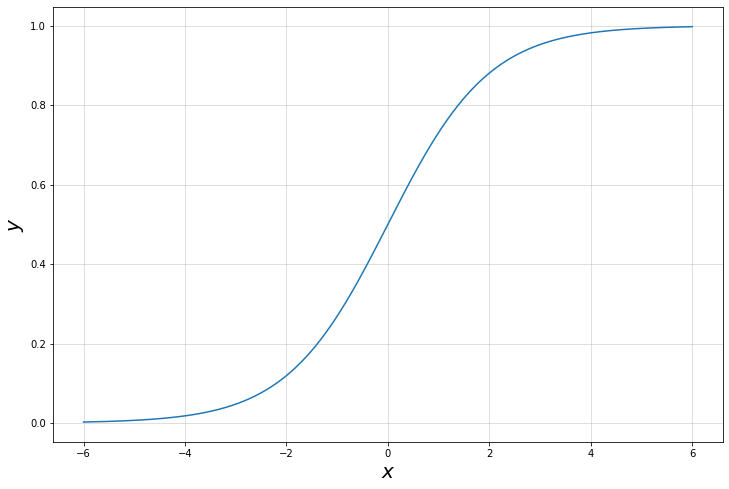

In [3]:
plt.figure(figsize=(12,8))
x = np.linspace(-6, 6, 1000)
y = logistic(x)
plt.xlabel(r'$x$', size=20)
plt.ylabel(r'$y$', size=20)
plt.grid(alpha=0.5)
plt.plot(x, y);

#### Questions:
1. Can you already guess why this _regression_ model is used in _binary classification_ tasks?
2. What do the bounds of the logistic function tell you?

Let's generate a data set with sklearn's [`make_classification`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html) function:

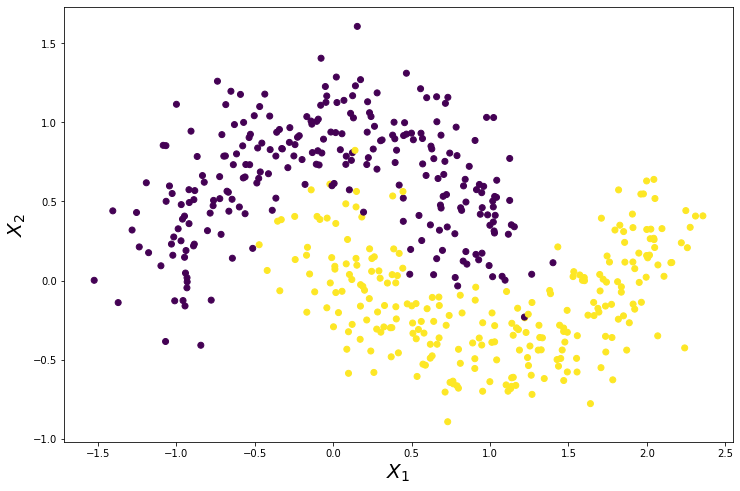

In [4]:
#X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2, n_clusters_per_class=1, random_state=1)
X, y = make_moons(n_samples=500, noise=0.2, random_state=1)
plt.figure(figsize=(12,8))
plt.xlabel(r'$X_1$', size=20)
plt.ylabel(r'$X_2$', size=20)
plt.scatter(X[:,0],X[:,1], c=y.reshape(-1));

We divide the data set into train and test sets and run our model with your own choice of hyperparameters:

In [5]:
# stacking data X and labels y into one matrix
data = np.hstack((X, y[:, np.newaxis]))

# shuffling the rows        
np.random.shuffle(data)

# we split train to test as 70:30
split_rate = 0.7
train, test = np.split(data, [int(split_rate*(data.shape[0]))])

X_train = train[:,:-1].T
y_train = train[:, -1]

X_test = test[:,:-1].T
y_test = test[:, -1]

y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [6]:
X_train.shape

(2, 350)

In [7]:
y_train.shape

(350,)

In logistic regression, we learn parameters $\boldsymbol \beta$ and $\beta_0$ similar to linear regression, but pass the output through a logistic function in the end. We call the output of this operation $\hat{\boldsymbol y}_{\text{log}}$:
$$
\hat{\boldsymbol y}_{\text{log}} = f(\boldsymbol \beta^T \boldsymbol X + \beta_0)
$$
where $\boldsymbol X = [X^{(1)}, X^{(2)}, \dots, X^{(n)}]$, and $X^{(i)} \in \mathbb R^d$.

Note that $f$ is again the logistic function and, consequently, we have a _probability_ of the given data point belonging to one of the two classes, let's say red and blue. Then, you simply label any data point with probability greater than $0.5$ red, and any data point with probability less or equal to $0.5$ blue.

Implement this function in the next cell.

In [8]:
## EDIT THIS FUNCTION
def predict_log(X, beta, beta_0):
  y_log = logistic(beta.T @ X + beta_0) ## <-- SOLUTION
  return y_log

A common technique in machine learning is to initialise the parameters $\boldsymbol \beta$ and $\beta_0$ randomly or with zeros; we do the latter here.

In [9]:
def initialise(d):
    """    
    Argument:
    d: size of the beta vector (or number of parameters)

    Returns:
    beta: initialised vector of shape (d, 1)
    beta_0: initialised scalar (corresponds to the offset)
    """

    beta = np.zeros(shape=(d, 1), dtype=np.float32)
    beta_0 = 0

    assert(beta.shape==(d, 1))
    assert(isinstance(beta_0, float) or isinstance(beta_0, int))

    return beta, beta_0

From our lectures we know that the cost function to be minimised is given by
$$
\mathcal L = - \frac{1}{n} \sum_{i=1}^n y^{(i)} \log(\hat{y}_{\text{log}}^{(i)}) + (1-y^{(i)}) \log (1-\hat{y}_{\text{log}}^{(i)}) \, .
$$
We will use gradient descent to optimise this cost function. The derivatives with respect to $\boldsymbol \beta$ and $\beta_0$ are:
$$
\frac{\partial \mathcal L}{\partial \boldsymbol \beta} = \frac{1}{n} \sum_{i=1}^n ( y^{(i)} - \hat{y}_{\text{log}}^{(i)}) X^{(i)}
$$
 
$$
\frac{\partial \mathcal L}{\partial \beta_0} = \frac{1}{n} \sum_{i=1}^n ( y^{(i)} - \hat{y}_{\text{log}}^{(i)})
$$

Implement the cost function and its derivatives in the next cell as part of a larger operation which we shall call `propagate`, which is often also called a _forward pass_.

In [10]:
## EDIT THIS FUNCTION
def propagate(X, y, beta, beta_0):
    """
    Arguments:
    X: data of size (d, n)
    y: true label vector of size (1, n)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar

    Returns:
    cost: negative log-likelihood cost for logistic regression
    dbeta: gradient of the loss with respect to beta
    dbeta_0: gradient of the loss with respect to beta_0
    """
    n = X.shape[1]
    y_log = predict_log(X, beta, beta_0)

    # cost function
    cost = (-1) * np.mean(np.multiply(y, np.log(y_log)) + np.multiply(1-y, np.log(1 - y_log)), axis=1) ## <-- SOLUTION (hint: don't forget axis=1 when using np.mean)

    # derivatives
    dbeta = (1/n) * X @ np.transpose(y_log - y)  ## <-- SOLUTION
    dbeta_0 =  np.mean((y_log - y)) ## <-- SOLUTION

    assert(dbeta.shape==beta.shape)
    assert(dbeta_0.dtype==float)
    cost = np.squeeze(cost)
    assert(cost.shape==())

    # store gradients in a dictionary
    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}

    return grads, cost

With these gradients and the cost, we can conduct the actual optimisation and update the $\boldsymbol \beta$ and $\beta_0$ with a learning rate $\alpha$, which we shall set to $0.005$. You are required to implement the updating procedure.

In [17]:
## EDIT THIS FUNCTION
def optimise(X, y, beta, beta_0, num_iterations=1000, learning_rate=0.005, print_cost=False):
    """
    Arguments:
    X: data of size (d, n)
    y: true label vector of size (1, n)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar
    num_iterations: number of iterations gradient descent shall update the parameters
    learning_rate: step size in updating procedure
    print_cost: whether to print the cost every 100 iterations or not

    Returns:
    params: dictionary containing the parameters beta and offset beta_0
    grads: dictionary containing the gradients
    costs: list of all the costs computed during the optimisation (can be used to plot the learning curve).
    """
    costs = []
    
    for i in range(num_iterations):

        # calculate cost and gradients
        grads, cost = propagate(X, y, beta, beta_0)  ## <-- SOLUTIONS

        # retrieve derivatives from grads
        dbeta = grads["dbeta"]
        dbeta_0 = grads["dbeta_0"]

        # updating procedure
        beta = beta - learning_rate * dbeta  ## <-- SOLUTION
        beta_0 = beta_0 - learning_rate * dbeta_0  ## <-- SOLUTION

        # record the costs
        if i % 100 == 0:
            costs.append(cost)

        # print the cost every 100 iterations
        if print_cost and i % 100 == 0:
            print ("cost after iteration %i: %f" %(i, cost))

    # save parameters and gradients in dictionary
    params = {"beta": beta, "beta_0": beta_0}
    grads = {"dbeta": dbeta, "dbeta_0": dbeta_0}

    return params, grads, costs

Having calculated the parameters for our training sets, we can finally predict the labels for our test set.

In [20]:
## EDIT THIS FUNCTION
def predict(X_test, beta, beta_0):
    """
    Arguments:
    X_test: test data of size (d, n)
    beta: parameters, a numpy array of size (d, 1)
    beta_0: offset, a scalar

    Returns:
    y_pred: vector containing all binary predictions (0/1) for the examples in X_test
    """
    n = X_test.shape[1]
    y_pred = np.zeros((1,n))
    beta = beta.reshape(X_test.shape[0], 1)

    # compute vector y_log predicting the probabilities
    y_log = predict_log(X_test, beta, beta_0)

    for i in range(y_log.shape[1]):

      # convert probabilities y_log to actual predictions y_pred
        if y_log[0, i] > 0.5:
            y_pred[0, i] = 1  ## <-- SOLUTION
        else:
            y_pred[0, i] = 0  ## <-- SOLUTION
  
    assert(y_pred.shape==(1, n))

    return y_pred

A pythonic way to define an algorithm is placing all functions in one model that has all hyperparameters as arguments. This allows you to quickly evaluate different hyperparameters and optimise over these. So, let's do this:

In [21]:
def model(X_train, y_train, X_test, y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    # initialize parameters with zeros
    beta, beta_0 = initialise(X_train.shape[0])

    # gradient descent
    parameters, grads, costs = optimise(X_train, y_train, beta, beta_0, num_iterations, learning_rate, print_cost=print_cost)

    # retrieve parameters beta and beta_0 from dictionary "parameters"
    beta = parameters["beta"]
    beta_0 = parameters["beta_0"]

    # predict test and train set examples
    y_pred_test = predict(X_test, beta, beta_0)
    y_pred_train = predict(X_train, beta, beta_0)

    # print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(y_pred_train - y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(y_pred_test - y_test)) * 100))

    # saving all information
    d = {"costs": costs, "y_pred_test": y_pred_test, "y_pred_train": y_pred_train, "beta": beta, "beta_0": beta_0, "learning_rate": learning_rate, "num_iterations": num_iterations}

    return d

In [22]:
# run the model
d = model(X_train, y_train, X_test, y_test, num_iterations=500, learning_rate=0.1, print_cost=True)

cost after iteration 0: 0.693147
cost after iteration 100: 0.399077
cost after iteration 200: 0.352676
cost after iteration 300: 0.332842
cost after iteration 400: 0.321343
train accuracy: 86.0 %
test accuracy: 87.33333333333333 %


Let's see how our cost has changed over the training iterations:

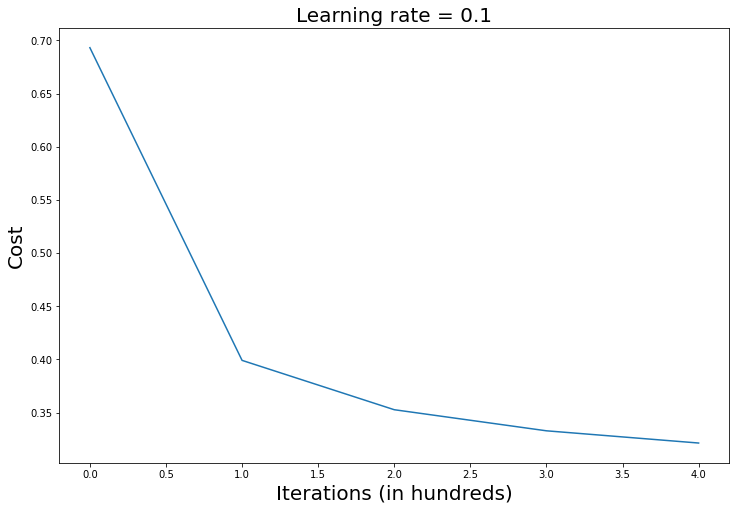

In [15]:
costs = np.squeeze(d['costs'])
plt.figure(figsize=(12,8))
plt.ylabel('Cost', size=20)
plt.xlabel('Iterations (in hundreds)', size=20)
plt.title("Learning rate = " + str(d["learning_rate"]), size=20)
plt.plot(costs);

#### Questions:
1. What insights do you gain from this learning curve?
2. Try different learning rates, run the model again, and plot the learning curve. What can you observe?
3. Use different random states when you generate the data and run the model again. What can you observe?
4. Increase the number of features in your generated data and evaluate the accuracies again. How do they change?
5. Generate data with sklearn's [`make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function (noise $> 0.1$) and evaluate how well logistic regression performs on this data set.